# Week 4 Day 2 lab
## Solving the Knapsack problem using VQE

The knapsack problem is a problem in combinatorial optimization: Given a set of items, each with a weight and a value, determine the number of each item to include in a collection so that the total weight is less than or equal to a given limit and the total value is as large as possible. It derives its name from the problem faced by someone who is constrained by a fixed-size knapsack and must fill it with the most valuable items. The problem often arises in resource allocation where the decision makers have to choose from a set of non-divisible projects or tasks under a fixed budget or time constraint, respectively.

Let's make the needed imports:

In [1]:
# BLOCK 1 - Importing libaries. A lot of new libararies here! 

from qiskit_optimization.applications import Knapsack
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2, TwoLocal

# Our typical libraries
import numpy as np
from qiskit import QuantumCircuit, execute, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_textbook.tools import array_to_latex

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

print("All libraries imported successfully!")

All libraries imported successfully!


## Part 1 - Setting up the problem

In [2]:
# BLOCK 2 - Defining the knapsack problem. We define a list of values, a list of weights, the maximum weight, and then
# put it all together into a variable called `problem' using the Knapsack function.
values = [4, 2, 5, 10, 3, 6]   # list of the values of items
weights = [3, 1, 2, 6, 7, 3]   # list of the weights of items
max_weight = 15            # maximum weight capacity (knapsack capacity)

knapsack_problem = Knapsack(values = values, weights = weights, max_weight = max_weight) #putting it all together

## Part 2 - Using a classical method to solve the problem

In [3]:
# BLOCK 3- Choosing the method of solving the knapsack problem. Since this is a small problem, 
#we can check the answer we will get later with VQE using a classical solver. 
# The method we will use to solve is called `NumPyMinimumEigensolver'.
# We create a variable called method, and store the method we want to use 
#(NumPyMinimumEigensolver) in it.
# Later, we will use VQE instead of the classical NumPyMinimumEigensolver.

method = NumPyMinimumEigensolver()

In [4]:
# BLOCK 4 - Using the classical solver NumPyMinimumEigensolver. 
# Run this block to use the classical solver defined in Block 2 
# to solve the knapsack problem defined in Block 1.

calc = MinimumEigenOptimizer(method)
result = calc.solve(knapsack_problem.to_quadratic_program())
print('result:\n', result)
print('\nsolution:\n', knapsack_problem.interpret(result))

result:
 optimal function value: 27.0
optimal value: [1. 1. 1. 1. 0. 1.]
status: SUCCESS

solution:
 [0, 1, 2, 3, 5]


## Part 3 - Using VQE to solve the problem

In [5]:
# BLOCK 5 - Converting the knapsack problem to a quantum circuit, 
# i.e., a colletion of quantum gates (or operators).
# Run this block to convert the knapsack problem to a quantum operator, 
# and print the number of qubits used.

operator, offset = QuadraticProgramToQubo().convert(knapsack_problem.to_quadratic_program()).to_ising()
print("number of qubits =",operator.num_qubits)

number of qubits = 10


In [6]:
# BLOCK 6 - Setting up VQE. We define a QuantumInstance, which is a way of specifying which simulator we want to use.
# We define our tunable circuit for VQE. Here, we will choose EfficientSU2
# We define which classical optimizer we want to use - here we will use one called SPSA
# We tell our code to use VQE with the tunable circuit, the optimizer, and the quantum instance

qinstance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000)


tunable_circuit = EfficientSU2(operator.num_qubits, reps=3, entanglement='full')
#tunable_circuit = TwoLocal(operator.num_qubits, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', reps=3, entanglement='full')
optimizer = SPSA(maxiter=15)

method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = qinstance)

In [7]:
# BLOCK 7 - Running VQE and printing results. This is the same code as in Block 2. T
#he only difference is that here, the method is VQE and not the classical NumPyMinimumEigensolver.

calc = MinimumEigenOptimizer(method)
result = calc.solve(knapsack_problem.to_quadratic_program())
print('result:\n', result)
print('\nsolution:\n', knapsack_problem.interpret(result))
#print('\ntime:', result.min_eigen_solver_result.optimizer_time)

result:
 optimal function value: 27.0
optimal value: [1. 1. 1. 1. 0. 1.]
status: SUCCESS

solution:
 [0, 1, 2, 3, 5]


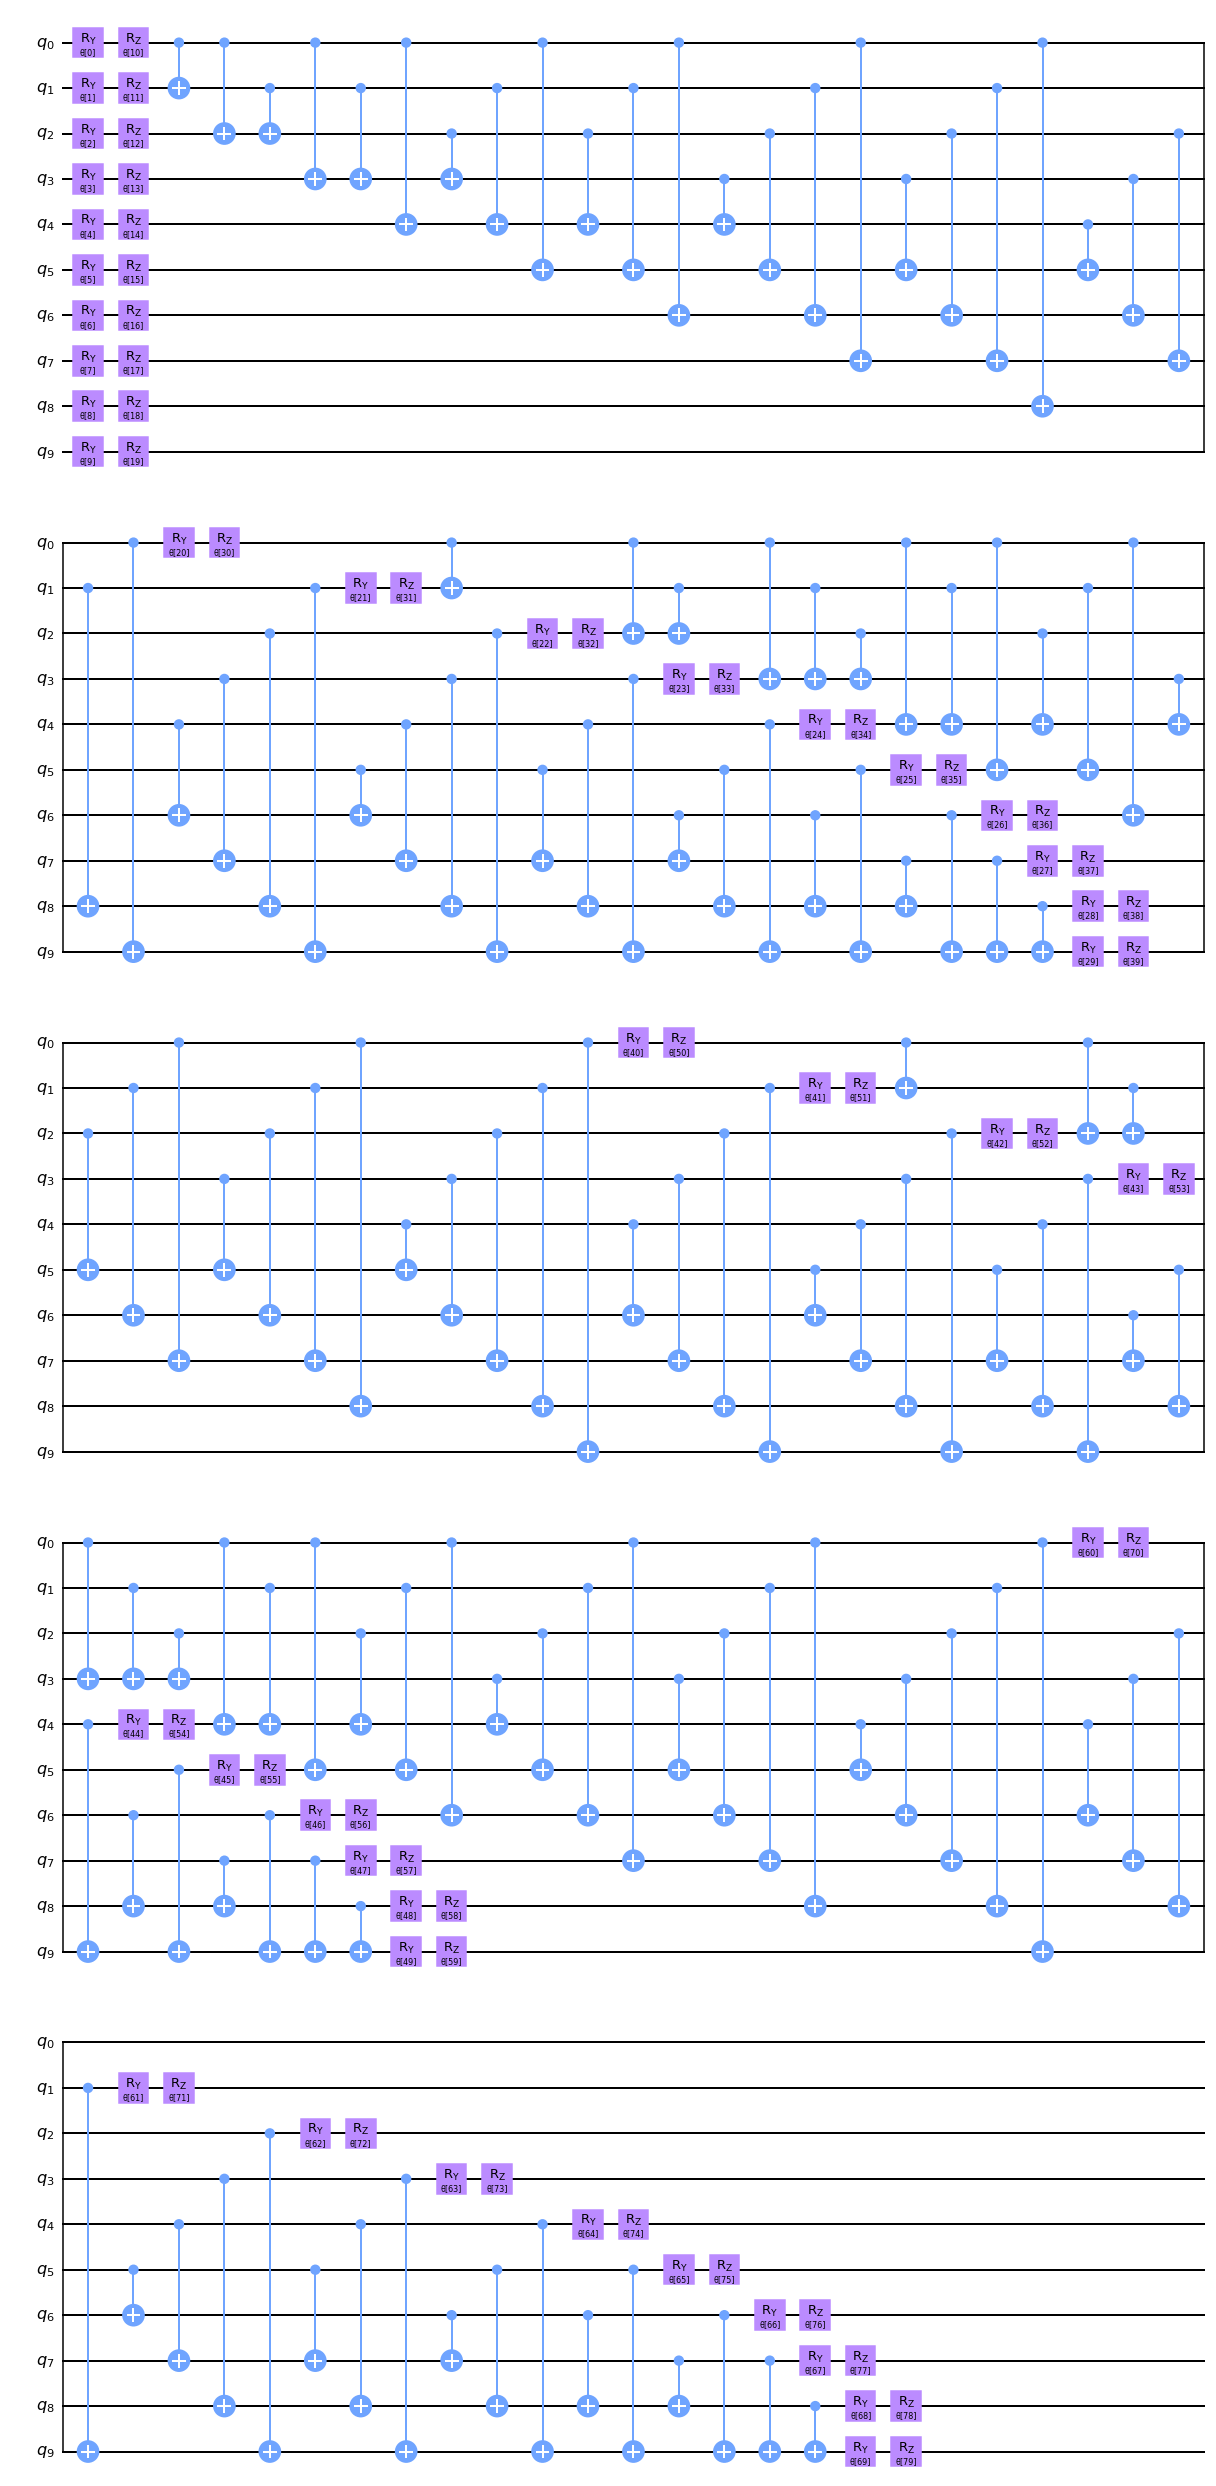

In [8]:
# BLOCK 8 - Drawing the tunable circuit. 
tunable_circuit.decompose().draw()


# Tunable gates

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


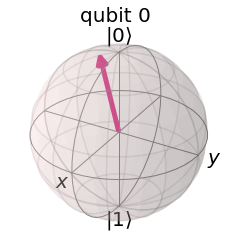

In [9]:
# BLOCK 9 - The Rx gate. try changing the angle and see what the Rx gate does.

angle = 15
qc = QuantumCircuit(1)
qc.rx(angle*np.pi/180,0)

svsim = Aer.get_backend('statevector_simulator')
job = execute(qc,svsim)
result = job.result()

state = result.get_statevector()
plot_bloch_multivector(state)

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


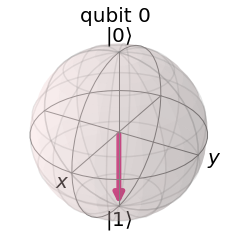

In [10]:
# BLOCK 10 - The Ry gate. try changing the angle and see what the Ry gate does.

angle = 180
qc = QuantumCircuit(1)
qc.ry(angle*np.pi/180,0)

svsim = Aer.get_backend('statevector_simulator')
job = execute(qc,svsim)
result = job.result()

state = result.get_statevector()
plot_bloch_multivector(state)

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


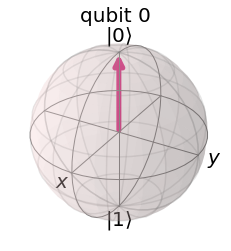

In [11]:
# BLOCK 11 - The Rz gate. try changing the angle and see what the Rz gate does.

angle = 180
qc = QuantumCircuit(1)
qc.rz(angle*np.pi/180,0)

svsim = Aer.get_backend('statevector_simulator')
job = execute(qc,svsim)
result = job.result()

state = result.get_statevector()
plot_bloch_multivector(state)